In [1]:
# The basics
%matplotlib inline
import matplotlib.pyplot as plt
import time
import itertools
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from collections import deque

import numpy as np
import sys
import os
import random
from collections import namedtuple
import collections
import copy

# Import the open AI gym
import gym

# Keras and backend for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf

# Misc
import warnings
warnings.filterwarnings('ignore')

print(sys.version)
print(os.path)
print("Keras: ",keras.__version__)
print("TF: ",tf.__version__)
print("\n\nYou are good to go")

#import environment
sys.path.append(r'../virl')
import virl

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
<module 'posixpath' from '/Users/wayenvan/opt/anaconda3/lib/python3.8/posixpath.py'>
Keras:  2.4.3
TF:  2.3.1


You are good to go


## Training phase

### define the approximator and q_learning agent

In [2]:

#define approximator
class NNFunctionApproximatorJointKeras():
    """ A basic MLP neural network approximator and estimator using Keras     
    """
    
    def __init__(self, alpha, d_states, n_actions, nn_config, verbose=False):        
        self.alpha = alpha    
        self.nn_config = nn_config      # determines the size of the hidden layer (if any)             
        self.n_actions = n_actions        
        self.d_states = d_states
        self.verbose=verbose # Print debug information        
        self.n_layers = len(nn_config)                
        self.model = self._build_model()                
                        
    def _huber_loss(self,y_true, y_pred, clip_delta=1.0):
        """
        Huber loss (for use in Keras), see https://en.wikipedia.org/wiki/Huber_loss
        The huber loss tends to provide more robust learning in RL settings where there are 
        often "outliers" before the functions has converged.
        """
        error = y_true - y_pred
        cond  = K.abs(error) <= clip_delta
        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning 
        model = Sequential()
        for ilayer in self.nn_config:
            model.add(Dense(ilayer, input_dim=self.d_states, activation='relu'))        
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss=self._huber_loss, # define a special loss function
                      optimizer=Adam(lr=self.alpha, clipnorm=10.)) # specify the optimiser, we clip the gradient of the norm which can make traning more robust
        return model

    def predict(self, s, a=None):              
        if a==None:            
            return self._predict_nn(s)
        else:                        
            return self._predict_nn(s)[a]
        
    def _predict_nn(self,state_hat):                          
        """
        Predict the output of the neural netwwork (note: these can be vectors)
        """                
        x = self.model.predict(state_hat)                                                    
        return x
  
    def update(self, states, td_target):           
        self.model.fit(states, td_target, epochs=1, verbose=0) # take one gradient step usign Adam               
        return 

In [19]:
#define a replay buffer
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','is_not_terminal_state'))

class ReplayMemory():
    """
    Implement a replay buffer using the deque collection
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)               

    def push(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))

    def pop(self):
        return self.memoery.pop()

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)   

    def __len__(self):
        return len(self.memory)

In [20]:
# Keep track of some stats
EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

#define a q_learning agent with
def q_learning_nn(env, func_approximator, func_approximator_target, num_episodes,max_steps_per_episode=500,discount_factor=0.95, epsilon_init=0.01, epsilon_decay=0.99995,epsilon_min=0.01,use_batch_updates=True, fn_model_in=None, fn_model_out=None):
    """
    Q-Learning algorithm for Q-learning using Function Approximations.
    Finds the optimal greedy policy while following an explorative greedy policy.
    
    Args:
        env: OpenAI environment.bb
        func_approximator: Action-Value function estimator, behavior policy (i.e. the function which determines the next action)
        func_approximator_target: Action-Value function estimator, updated less frequenty than the behavior policy 
        num_episodes: Number of episodes to run for.
        max_steps_per_episode: Max number of steps per episodes
        discount_factor: Gamma discount factor.
        epsilon_init: Exploration strategy; chance the sample a random action. Float between 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
        epislon_min: Min epsilon value        
        use_batch_updates=True, 
        fn_model_in: Load the model from the file if not None
        fn_model_out: File name of the saved model, saves the best model in the last 100 episodes

    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
        
    memory = ReplayMemory(BUFFER_SIZE) # init the replay memory    
    n_actions = env.action_space.n        
    d_states  = env.observation_space.shape[0]    
    best_reward = 0

    # Synch the target and behavior network
    if not fn_model_in is None:
        func_approximator.model.load_weights(fn_model_in)
    func_approximator_target.model.set_weights(func_approximator.model.get_weights())

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))            

    epsilon = epsilon_init

    for i_episode in range(num_episodes):
        
        sys.stdout.flush()
               
        # Reset the environment and pick the first action
        state = env.reset()
        state = np.reshape(state, [1, d_states]) # reshape to the a 1xd_state numpy array
        
        # One step in the environment
        for t in range(max_steps_per_episode):#itertools.count():

            # Select an action usign and epsilon greedy policy based on the main behavior network
            if np.random.rand() <= epsilon:
                action = random.randrange(n_actions)
            else:
                act_values = func_approximator.predict(state)[0]
                action = np.argmax(act_values)  # returns action                        
            
            # Take a step            
            next_state, reward, done, _ = env.step(action)                        
            next_state = np.reshape(next_state, [1, d_states] )
            
            # Add observation to the replay buffer
            if done:
                memory.push(state, action, next_state, reward, 0.0)            
            else:
                memory.push(state, action, next_state, reward, 1.0)            
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
                     
            # Update network (if learning is on, i.e. alpha>0 and we have enough samples in memory)
            if func_approximator.alpha > 0.0 and len(memory) >= BATCH_SIZE:                         
                # Fetch a bacth from the replay buffer and extract as numpy arrays 
                transitions = memory.sample(BATCH_SIZE)            
                batch = Transition(*zip(*transitions))                                
                train_rewards = np.array(batch.reward)
                train_states = np.array(batch.state)
                train_next_state = np.array(batch.next_state)
                train_actions = np.array(batch.action)
                train_is_not_terminal_state = np.array(batch.is_not_terminal_state) # 
                                
                if(use_batch_updates):
                    # Do a single gradient step computed based on the full batch
                    train_td_targets    = func_approximator.predict(train_states.reshape(BATCH_SIZE,4)) # predict current values for the given states
                    q_values_next       = func_approximator_target.predict(np.array(batch.next_state).reshape(BATCH_SIZE,d_states))                    
                    train_td_targetstmp = train_rewards + discount_factor * train_is_not_terminal_state * np.amax(q_values_next,axis=1)                
                    train_td_targets[ (np.arange(BATCH_SIZE), train_actions.reshape(BATCH_SIZE,).astype(int))] = train_td_targetstmp                                                                              
                    func_approximator.update(train_states.reshape(BATCH_SIZE,d_states), train_td_targets) # Update the function approximator using our target       
                else:
                    # Do update in a truely online sense where a gradient step is performaed per observation
                    for s in range(train_rewards.shape[0]):                        
                        target = func_approximator.predict(train_states[s])[0]
                        q_next = func_approximator_target.predict(train_next_state[s])[0]
                        target[train_actions[s]] = train_rewards[s] + discount_factor * train_is_not_terminal_state[s] * np.amax(q_next)                        
                        func_approximator.update(train_states[s], target.reshape(1,n_actions)) # Update the function approximator using our target                                            
                if epsilon > epsilon_min:
                    epsilon *= epsilon_decay
            
            state = next_state                
            
            # 
            if done:
                # Synch the target and behavior network
                func_approximator_target.model.set_weights(func_approximator.model.get_weights())
              
                print("\repisode: {}/{}, score: {}, epsilon: {:.2}".format(i_episode, num_episodes, t, epsilon), end="")                               

                # Save the best model so far    
                if fn_model_out is not None and (t >= best_reward):
                    func_approximator.model.save_weights(fn_model_out)
                    best_reward = t
                
                break
            
    return stats

In [21]:
def load_approximator(func_approximator_target, fn_model_in):
    """load an approximator from file"""
    if not fn_model_in is None:
        func_approximator_target.model.load_weights(fn_model_in)

### start training

In [22]:
#create training environment, I am using P1
env_train = virl.Epidemic(stochastic=False, noisy=False) 

d_states = env_train.observation_space.shape[0]
n_actions = env_train.action_space.n

alpha = 0.001
nn_config = [36,36,36]
BATCH_SIZE = 20
BUFFER_SIZE = 10000

# Init the tow networks
nn_func_approximator = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
nn_func_approximator_target = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)

# Training   
stats = q_learning_nn(env_train,nn_func_approximator, nn_func_approximator_target, 1000, max_steps_per_episode=400, 
                      epsilon_init=0.1, epsilon_decay=0.995, epsilon_min=0.001, fn_model_out=r"./cartpole_temp.h5")

episode: 999/1000, score: 51, epsilon: 0.001

## Evaluation phase
Define a exec step function to make step using the approximator

In [23]:
def policy_generator(env, epsilon, approximator, policy_type="random"):
    """
    Creates an greedy policy with the exploration defined by the epsilon and nA parameters
    
    Input:
        epsilon: The probability to select a random action . float between 0 and 1.
        env: The environment
        policy_type: The type of policy, either random or greedy
    
    Output:
        A function that takes the observation as an argument and returns an action
    """
    def random_policy(s):
        action=np.random.choice(env.action_space.n)
        return action
    
    def greedy_policy(s):
         # Select an action usign and epsilon greedy policy based on the main behavior network
        if np.random.rand() <= epsilon:
            action = random.randrange(env.action_space.n)
        else:
            act_values = approximator.predict(np.reshape(s, [1, env.observation_space.shape[0]]))[0]
            action = np.argmax(act_values)  # returns action
        return action
    
    if(policy_type=="random"):
        return random_policy
    if(policy_type=="greedy"):
        return greedy_policy
    else:
        return None

In [24]:
def exec_agent(policy, env):
    
    d_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    
    states = []
    rewards = []
    actions = []    
    
    #reset the environment
    state = env.reset()
    states.append(state)
    
    for i in itertools.count():
        action = policy(state)
        
        #exec the policy
        state, reward, done, _= env.step(action)
        
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        
        if done:
            break
            
    return states, rewards, actions

now apply the approximator

In [25]:
env = virl.Epidemic(problem_id=2) 

approximator_trained = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
load_approximator(approximator_trained, r"./cartpole_finished.h5")

epsilon_fixed = 0.1
policy_greedy = policy_generator(env,epsilon_fixed, approximator_trained, policy_type="greedy")
policy_random = policy_generator(env, epsilon_fixed, approximator_trained)

states_test1, rewards_test1, actions_test1 = exec_agent(policy_greedy, env)
states_test2, rewards_test2, actions_test2 = exec_agent(policy_random, env)

Plot all figures

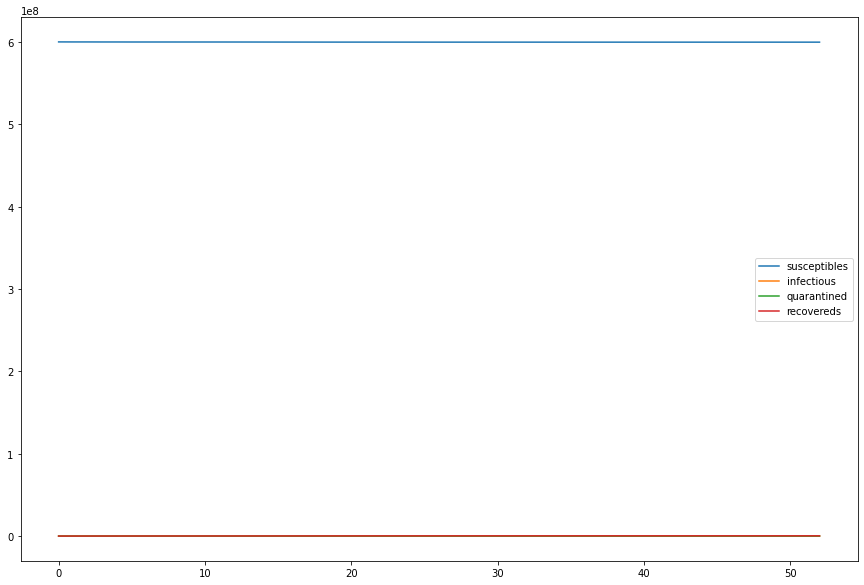

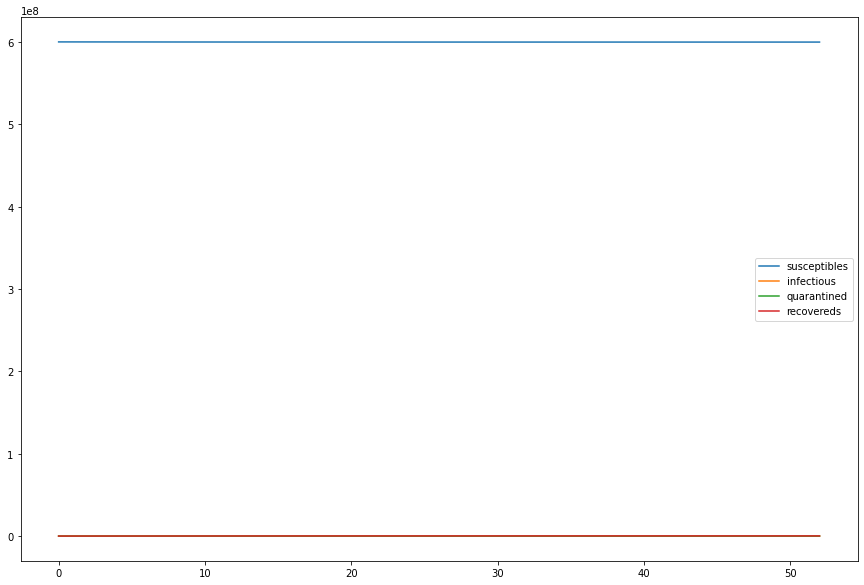

In [26]:
d_state_names=("susceptibles", "infectious", "quarantined", "recovereds")

plt.figure(figsize=(15,10))
for i in range(4):
    plt.plot(list(zip(*states_test2))[i], label=d_state_names[i])
plt.legend()

plt.figure(figsize=(15,10))
for i in range(4):
    plt.plot(list(zip(*states_test1))[i], label=d_state_names[i])
plt.legend()